In [186]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytensor.tensor as pt
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pymc as pm
import os
import sys
sys.path.append(os.path.abspath('../src'))
from data_tools import data_utils

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
project_dir = project_dir = Path.cwd().parent
trunc_D = 10

data_utils.create_data_split(
    start_year=2013,
    end_year=2020,
    D=trunc_D,
    data_folder_path = project_dir / "data",
    input_filename="DENGSP.csv",
    train_prop=0.7,
    val_prop=0.2,
    test_prop=0.1
)

/Users/jamieharris/Documents/GitHub/Imperial/Dengue-Nowcasting-Thesis/src/data_tools/data_utils.py:19: DtypeWarning: Columns (7,11,23,45,46,47,55,65,69,75,86,102) have mixed types. Specify dtype option on import or set low_memory=False.
  dengdf_raw = pd.read_csv(input_data_path, index_col=0)


In [57]:


%config InlineBackend.figure_format = 'retina'

RANDOM_SEED = 8998
rng = np.random.default_rng(RANDOM_SEED)

az.style.use("arviz-darkgrid")

def sampler_kwargs():
    return dict(
        nuts_sampler="nutpie",
        chains=2,
        draws=300,
        nuts_sampler_kwargs={"backend": "jax", "gradient_backend": "jax"},
        progressbar=False
    )

train_df = pd.read_csv(project_dir / "data" / "model" / "training_data.csv",
    parse_dates=True,
    date_format="%Y %b",
    index_col=0,
    dtype={"value": float},
)
y_true = train_df.sum(axis=1)
y_true.index = pd.to_datetime(y_true.index)
y_true.index.freq = y_true.index.inferred_freq
y_true


Date_Symptoms
2013-01-11    483
2013-01-12    521
2013-01-13    540
2013-01-14    674
2013-01-15    607
             ... 
2018-07-30     99
2018-07-31     65
2018-08-01     76
2018-08-02     76
2018-08-03     70
Freq: D, Length: 2031, dtype: int64

In [27]:
train_df

,delay_0,delay_1,delay_2,delay_3,delay_4,delay_5,delay_6,delay_7,delay_8,delay_9
Date_Symptoms,,,,,,,,,,
2013-01-11,53,55,35,116,64,54,65,39,1,1
2013-01-12,30,56,110,91,63,61,62,7,4,37
2013-01-13,21,113,100,70,69,55,8,8,71,25
2013-01-14,47,105,99,105,80,25,14,131,47,21
2013-01-15,51,119,87,70,28,23,115,66,29,19
...,...,...,...,...,...,...,...,...,...,...
2018-07-30,14,20,17,13,11,2,2,12,5,3
2018-07-31,7,20,13,12,4,3,2,2,2,0
2018-08-01,5,18,11,8,3,16,6,3,3,3


In [4]:
def mask_matrix(matrix, D):
        masked_matrix = matrix.copy()
        nrow, ncol = masked_matrix.shape

        for i in range(nrow):
            for j in range(ncol):
                if i + j > D - 1:
                     masked_matrix[i, j] = False
        return  masked_matrix


def create_fourier_features(t, n, p=365.25):
    x = 2 * np.pi * (pt.arange(n)+1) * t[:, None] / p
    return pt.concatenate((pt.cos(x), pt.sin(x)), axis = 1)


In [214]:
def proportion_net(Z_data, n_hidden, output_dim):
    T,D = Z_data.shape
    # Prior
    W1_net = pm.Normal("W1_net", mu=0, sigma=1, shape=(D, n_hidden))
    b1_net = pm.Normal("b1_net", mu=0, sigma=1, shape=(n_hidden,))

    W2_net = pm.Normal("W2_net", mu=0, sigma=1, shape=(n_hidden, n_hidden))
    b2_net = pm.Normal("b2_net", mu=0, sigma=1, shape=(n_hidden,))
    
    W3_net = pm.Normal("W3_net", mu=0, sigma=1, shape=(n_hidden, output_dim))
    b3_net = pm.Normal("b3_net", mu=0, sigma=1, shape=(output_dim,))
    
    # Forward pass
    h1 = pm.math.tanh(pm.math.dot(Z_data, W1_net) + b1_net)  # shape (T, n_hidden)
    h2 = pm.math.tanh(pm.math.dot(h1, W2_net) + b2_net)
    p_raw = pm.math.dot(h2, W3_net) + b3_net  # shape (T, D)
    
    return p_raw
    
    return p_raw
def get_GP_nowcast(Z_data, model_D, mask):
    t = np.arange(0, len(Z_data))
    t_min = t.min()
    t_max= t.max
    t_scaled = (t - t_min) / (t_max - t_min)

    with pm.Model() as dir_model:
        t_shared = pm.Data("t", t_scaled)
        Z_shared = pm.Data("Z_data", Z_data)

        # Linear trend parameters
        b0 = pm.Normal("b0", mu=0, sigma=1)   # intercept
        b1 = pm.Normal("b1", mu=0, sigma=1)
        mean_func = pm.gp.mean.Linear(coeffs=b1, intercept=b0)


        ell = pm.Gamma("ell", alpha=2, beta=1)
        eta = pm.HalfNormal("eta", sigma=1)
        cov_func = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell)

        # Use Hilbert space approximation
        gp = pm.gp.HSGP(m=[30], c=1.2, cov_func=cov_func, mean_func=mean_func)
        

        # GP prior over f
        f = gp.prior("f", X=t_shared[:,None])
    

        # fourier_shared = create_fourier_features(t_shared, n=10, p=3.5)
        # beta_fourier = pm.Normal("beta_fourier", 0, 0.1, shape=fourier_shared.shape[1])
        # seasonality = pm.Deterministic(
        #     "seasonality", pm.math.dot(fourier_shared, beta_fourier)
        # )
        
        log_lam = f
        lam = pm.Deterministic("lam", pm.math.exp(log_lam))

        
        p = pm.Dirichlet("p", a=np.ones(model_D))
        # p_raw = proportion_net(Z_shared, n_hidden=10, output_dim=model_D)
        # p = pm.Deterministic("p", pm.math.softmax(p_raw, axis=0))

        # Create matrix of lam[t,:] * p[t,d]
        mu = lam[:, None] * p[None, :]

        alpha = pm.HalfNormal("alpha", sigma=2)  # overdispersion param
        # y_hat = pm.NegativeBinomial("y_hat", mu=lam, alpha=alpha)

        
        z = pm.NegativeBinomial("z", mu[mask], alpha, observed=Z_data[mask])

        idata = pm.sample(nuts_sampler="numpyro", progressbar=False)
        
    lam_post_samples = az.extract(idata, group="posterior", num_samples=1000)["lam"]
    return lam_post_samples[-1,:].median()

In [215]:
from joblib import Parallel, delayed
import numpy as np

M=0
model_D=10
n_points = 10
Z_model_data = train_df.copy().iloc[0:n_points+M+model_D, 0:model_D]

def safe_fit_model(t):
    try:
        print(t-M-model_D)
        Z_data = Z_model_data.values[t-M-model_D: t].copy()
        mask = np.ones_like(Z_data, dtype=bool)
        mask[-model_D:] = mask_matrix(np.array(mask[-model_D:]), model_D)
        Z_data[~mask] = 0
        
        
        result = get_GP_nowcast(Z_data, model_D, mask)
        return result
    except Exception as e:
        print(f"Error in fit at t={t}: {e}")
        return None

# number of cores you want
n_jobs = 4

results = Parallel(n_jobs=n_jobs, backend="loky")(
    delayed(safe_fit_model)(t)
    for t in range(M+model_D, len(Z_model_data))
)

0
Error in fit at t=10: unsupported operand type(s) for -: 'builtin_function_or_method' and 'int'
4
Error in fit at t=14: unsupported operand type(s) for -: 'builtin_function_or_method' and 'int'
5
Error in fit at t=15: unsupported operand type(s) for -: 'builtin_function_or_method' and 'int'
1
6
Error in fit at t=16: unsupported operand type(s) for -: 'builtin_function_or_method' and 'int'
7
Error in fit at t=17: unsupported operand type(s) for -: 'builtin_function_or_method' and 'int'
8
Error in fit at t=18: unsupported operand type(s) for -: 'builtin_function_or_method' and 'int'
Error in fit at t=11: unsupported operand type(s) for -: 'builtin_function_or_method' and 'int'
9
Error in fit at t=19: unsupported operand type(s) for -: 'builtin_function_or_method' and 'int'
2
Error in fit at t=12: unsupported operand type(s) for -: 'builtin_function_or_method' and 'int'
3
Error in fit at t=13: unsupported operand type(s) for -: 'builtin_function_or_method' and 'int'


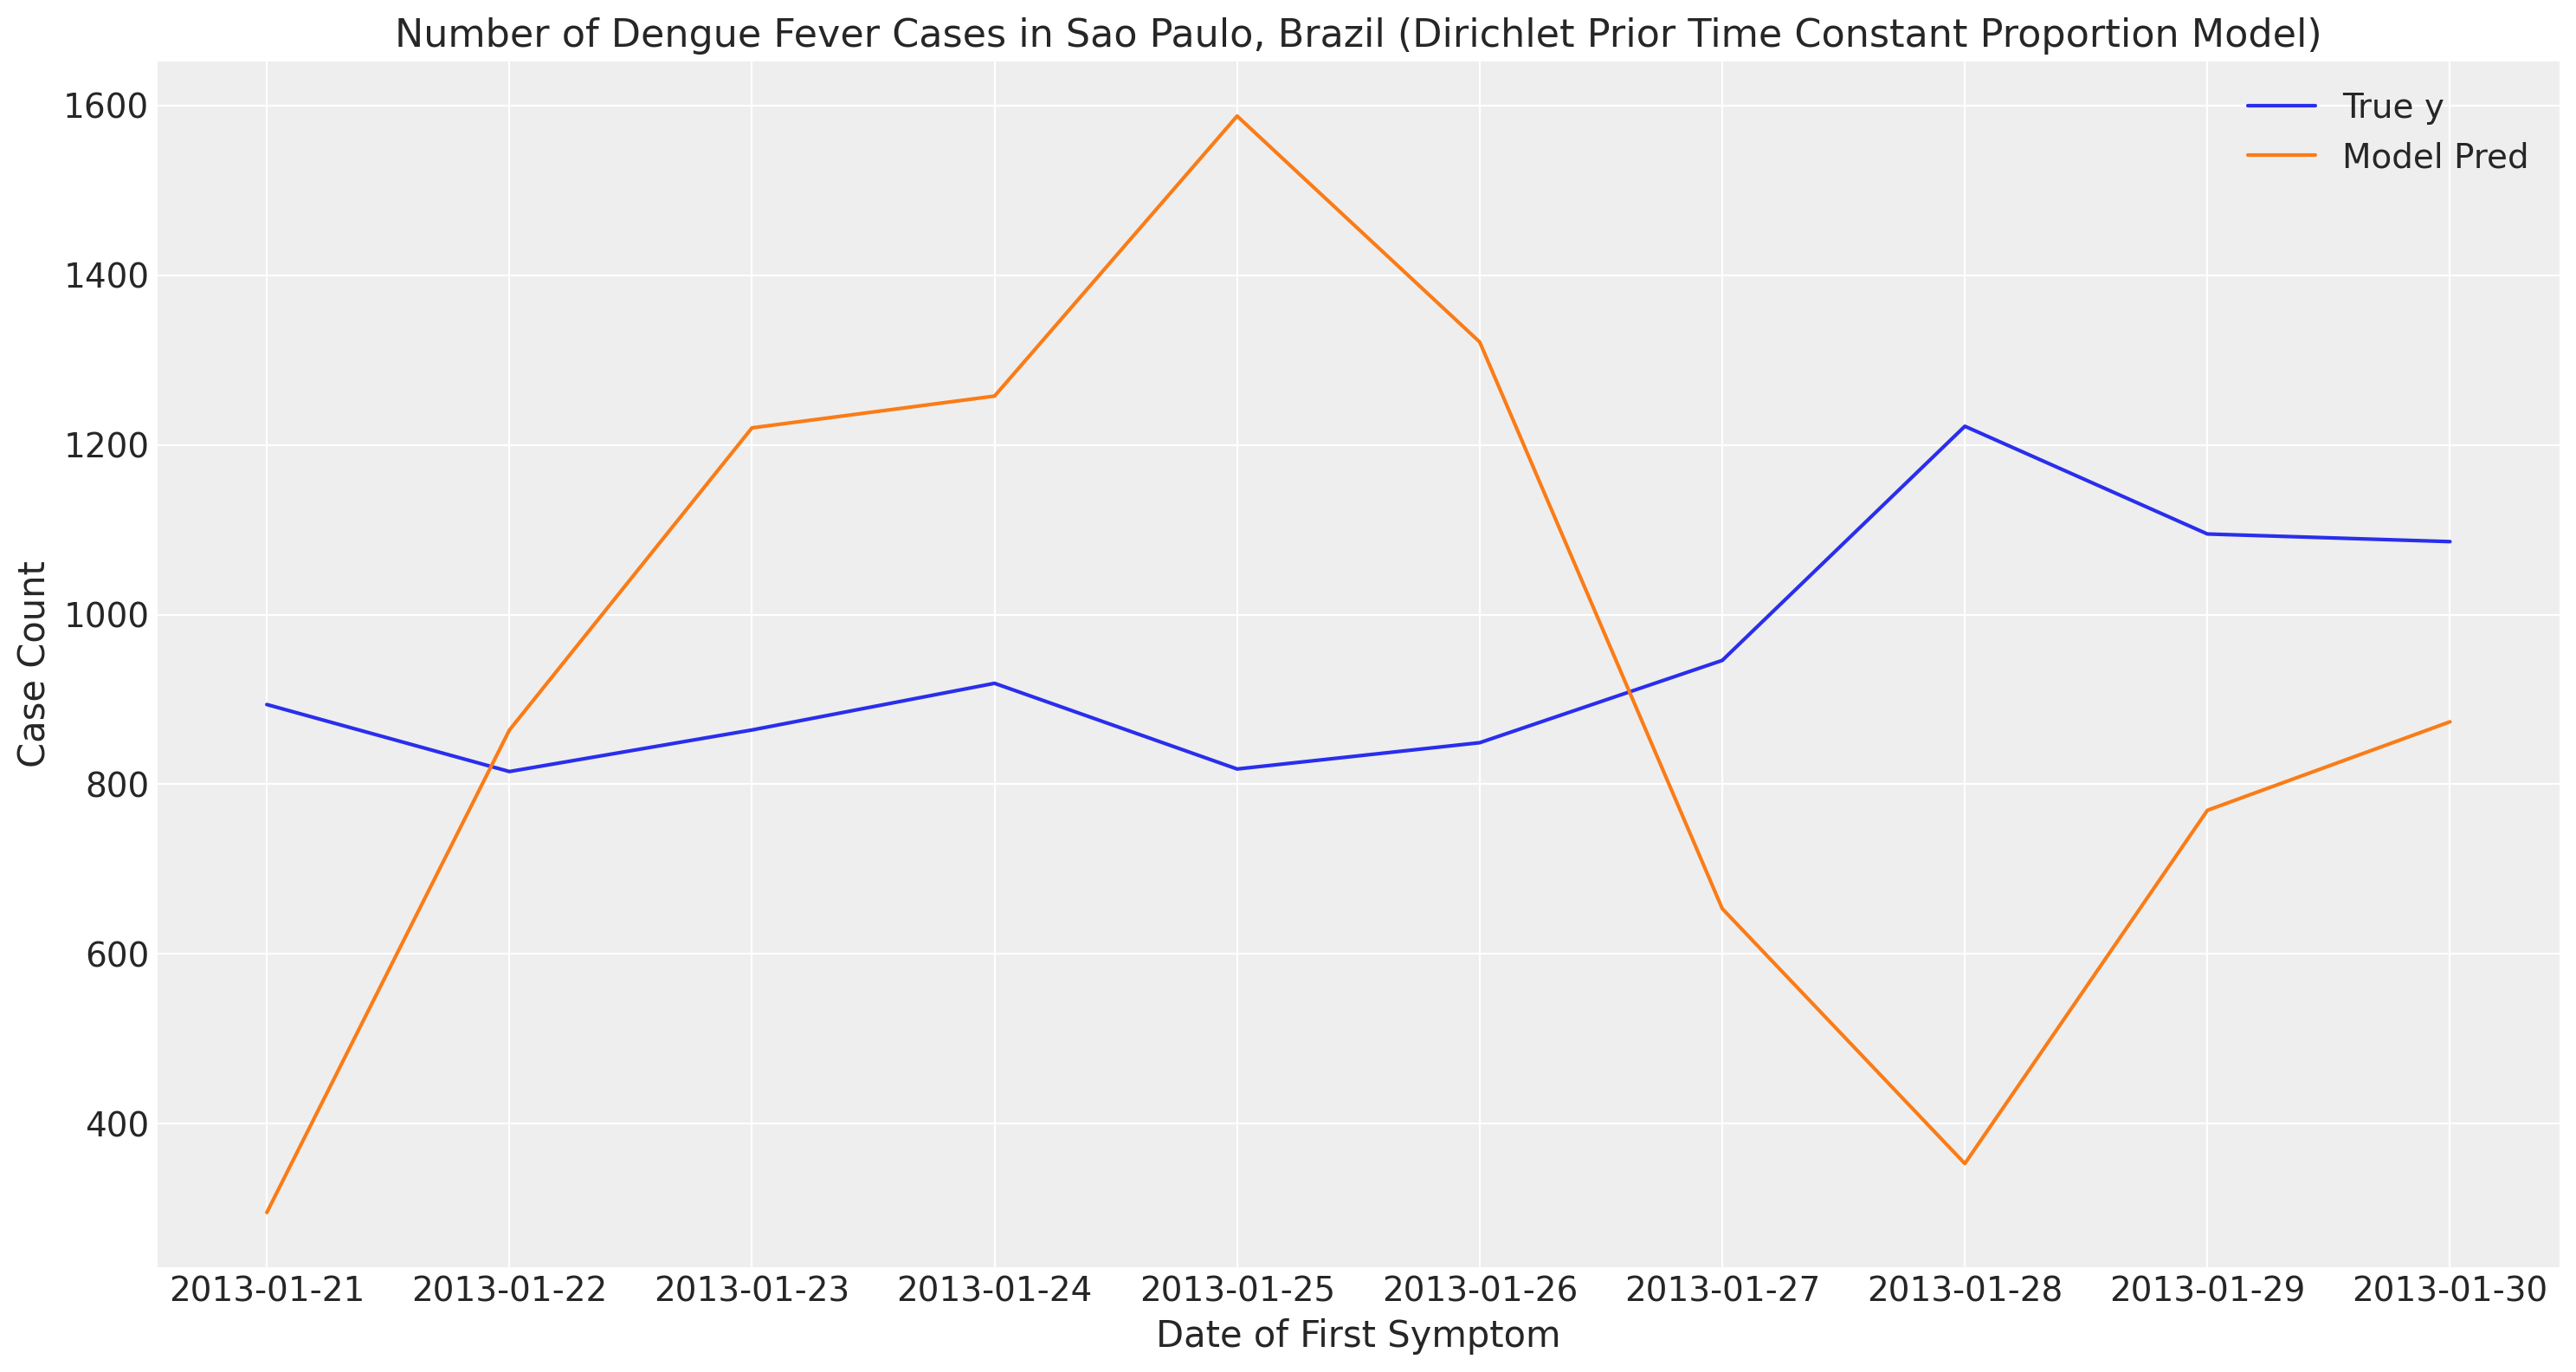

In [213]:
results = np.array(results)
y_model = y_true.iloc[M+model_D:M+model_D+n_points]

# # Plot stacked bars
plt.figure(figsize=(15, 8))
plt.plot(y_model.index, y_model, label="True y")
plt.plot(y_model.index, results, label="Model Pred")
plt.title("Number of Dengue Fever Cases in Sao Paulo, Brazil (Dirichlet Prior Time Constant Proportion Model)")
plt.xlabel("Date of First Symptom")
plt.ylabel("Case Count")
plt.legend()
plt.tight_layout()
plt.show()
